# Importing necessary libraries

In [1]:
# Working directory
import os

# Processing data
import pandas as pd
import numpy as np
import datetime

# Linear regression model
import statsmodels.api as sm

# t test
from scipy.stats import t

# Plotting
import matplotlib.pyplot as plt

# 1. Event definition

#### We are conducting an analysis to assess the impact of being deleted at first review  on stock market returns. 

In [2]:
# Defining the event window 
event_date = '2001-09-18'
event_start = -4
event_end = 5

# 2. Normal and abnormal returns

#### We use the market model to estimate normal returns, using the FTSE100 index as the market portfolio.

In [3]:
# Defining the market portfolio
market_ticker = 'FTSE'

# 3. Estimation procedure

#### We choose a 310-trading-days estimation window ending 10 days prior to the event window.

In [4]:
# Defining the estimation window
estimation_end = event_start - 10 - 1
estimation_start = estimation_end - (310 - 1)

### Importing data

In [5]:
# Importing historical data: market portfolio
data_market = pd.read_excel("stock_price_market100_converted.xlsx", skiprows=[1, 2])
data_market.head()

,Indexcd,Trddt,ExhcdOrIndexcd,IndexName,Clsidx
0,FTSE,2000-01-04,SPI,FTSE100,6665.9
1,FTSE,2000-01-05,SPI,FTSE100,6535.9
2,FTSE,2000-01-06,SPI,FTSE100,6447.2
3,FTSE,2000-01-07,SPI,FTSE100,6504.8
4,FTSE,2000-01-10,SPI,FTSE100,6607.7


In [6]:
data_market.rename(columns={'Indexcd': 'market_ticker', 'Trddt': 'trading_date', 'Clsidx': 'price'}, 
                   inplace=True)
data_market = data_market[['trading_date', 'market_ticker', 'price']]
data_market = data_market[data_market['market_ticker']==market_ticker]
data_market.head()

,trading_date,market_ticker,price
0,2000-01-04,FTSE,6665.9
1,2000-01-05,FTSE,6535.9
2,2000-01-06,FTSE,6447.2
3,2000-01-07,FTSE,6504.8
4,2000-01-10,FTSE,6607.7


In [7]:
## Calculating daily returns 
data_market['market_return'] = np.log(data_market['price']/data_market['price'].shift(1))
data_market = data_market[['trading_date', 'market_return']]
data_market.head()

,trading_date,market_return
0,2000-01-04,NaN
1,2000-01-05,-0.019695
2,2000-01-06,-0.013664
3,2000-01-07,0.008894
4,2000-01-10,0.015695


In [8]:
data_other_securities = pd.read_excel("stock_price_securities_other_five.xlsx", skiprows=[1])
data_other_securities.rename(columns={'Date': 'trading_date'}, inplace=True)
data_other_securities['trading_date'] = data_other_securities['trading_date'].dt.strftime('%Y-%m-%d')
data_other_securities['British Airways'] = np.log(data_other_securities['British Airways']/data_other_securities['British Airways'].shift(1))
data_other_securities['Canary Wharf'] = np.log(data_other_securities['Canary Wharf']/data_other_securities['Canary Wharf'].shift(1))
data_other_securities['Dimension Data'] = np.log(data_other_securities['Dimension Data']/data_other_securities['Dimension Data'].shift(1))
data_other_securities['Dixons'] = np.log(data_other_securities['Dixons']/data_other_securities['Dixons'].shift(1))
data_other_securities['Scottish and Newcastle'] = np.log(data_other_securities['Scottish and Newcastle']/data_other_securities['Scottish and Newcastle'].shift(1))
data_other_securities['United Utilities'] = np.log(data_other_securities['United Utilities']/data_other_securities['United Utilities'].shift(1))
data_other_securities.tail()
data_all = pd.merge(data_market, data_other_securities, on='trading_date', how='left')
data_all.head()


,trading_date,market_return,British Airways,Canary Wharf,Dimension Data,Dixons,Scottish and Newcastle,United Utilities
0,2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-05,-0.019695,0.002459,-0.013021,NaN,NaN,0.004151,0.014412
2,2000-01-06,-0.013664,-0.000614,0.013021,NaN,NaN,0.058046,0.038211
3,2000-01-07,0.008894,-0.003076,0.001293,NaN,NaN,0.044233,0.017445
4,2000-01-10,0.015695,-0.035752,-0.001293,NaN,NaN,-0.066820,0.016406


In [9]:
data_all.rename(columns={'British Airways': 'BA_return', 'Canary Wharf': 'CW_return', 'Dimension Data': 'DD_return', 'Dixons': 'DX_return', 'Scottish and Newcastle': 'SC_return', 'United Utilities': 'UU_return'}, inplace=True)
data_all.head()

,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return
0,2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-05,-0.019695,0.002459,-0.013021,NaN,NaN,0.004151,0.014412
2,2000-01-06,-0.013664,-0.000614,0.013021,NaN,NaN,0.058046,0.038211
3,2000-01-07,0.008894,-0.003076,0.001293,NaN,NaN,0.044233,0.017445
4,2000-01-10,0.015695,-0.035752,-0.001293,NaN,NaN,-0.066820,0.016406


In [10]:
index_event_day = data_all.index[data_all['trading_date']==event_date].tolist()

In [11]:
index_event_day

[432]

In [12]:
if index_event_day:
    data_all['event_time'] = 0
    for i in range(len(data_all)):
        data_all.loc[data_all.index[i], 'event_time'] = i - index_event_day[0]
else:
    print("No trading date matches the event date.")
data_all[(data_all['event_time']>=event_start) & (data_all['event_time']<=event_end)]

,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time
428,2001-09-12,0.028273,0.000000,0.029853,-0.005362,0.005333,0.006129,0.036368,-4
429,2001-09-13,0.012518,-0.059423,-0.009852,-0.021740,0.015831,0.050631,-0.001625,-3
430,2001-09-14,-0.038750,-0.172169,-0.028114,0.000000,-0.010527,-0.039492,-0.029705,-2
431,2001-09-17,0.029667,0.064539,-0.020577,-0.027857,-0.016000,0.034640,0.026448,-1
432,2001-09-18,-0.010300,-0.011429,-0.026865,-0.040351,-0.027249,0.001944,-0.008190,0
433,2001-09-19,-0.026542,-0.065305,-0.009118,-0.079553,0.048527,-0.009756,0.046595,1
434,2001-09-20,-0.035526,-0.130906,-0.019587,-0.139921,-0.135036,-0.002946,-0.019018,2
435,2001-09-21,-0.027408,0.061036,-0.057676,-0.003670,-0.030584,-0.032986,-0.016130,3
436,2001-09-24,0.039839,0.111918,0.068605,0.043172,0.042559,0.022111,-0.020535,4
437,2001-09-25,0.010671,0.026126,-0.007090,-0.014185,0.046521,-0.010492,0.025401,5


### Estimating the market model

In [13]:
data_all_estimation = data_all[(data_all['event_time']>=estimation_start) & (data_all['event_time']<=estimation_end)]
data_all_estimation.tail()

,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time
413,2001-08-21,0.013516,0.006390,-0.001910,-0.002240,-0.016807,-0.003824,0.000786,-19
414,2001-08-22,-0.003986,-0.017671,-0.011539,-0.020386,-0.008511,0.005731,-0.002359,-18
415,2001-08-23,-0.002258,0.015280,-0.008742,0.024860,0.070132,0.000000,0.001574,-17
416,2001-08-24,0.013875,0.021319,0.011639,0.026433,0.003976,0.006645,-0.002361,-16
417,2001-08-28,-0.006822,-0.010208,0.014361,0.008658,-0.032260,0.000946,0.003932,-15


In [14]:
print(len(data_all_estimation))
data_all_estimation.dropna(inplace=True)
print(len(data_all_estimation))

310
280


/var/folders/1s/plws044x63xc53g7y6vyflzh0000gn/T/ipykernel_45826/1162392699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all_estimation.dropna(inplace=True)


In [15]:
X_estimation = data_all_estimation['market_return']
X_estimation = sm.add_constant(X_estimation)

In [16]:
R1_estimation = data_all_estimation['BA_return']
market_model1 = sm.OLS(R1_estimation, X_estimation).fit()
print(market_model1.summary())

                            OLS Regression Results                            
Dep. Variable:              BA_return   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     17.61
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           3.65e-05
Time:                        21:27:17   Log-Likelihood:                 647.08
No. Observations:                 280   AIC:                            -1290.
Df Residuals:                     278   BIC:                            -1283.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.001     -0.267

In [17]:
R2_estimation = data_all_estimation['CW_return']
market_model2 = sm.OLS(R2_estimation, X_estimation).fit()
print(market_model2.summary())

                            OLS Regression Results                            
Dep. Variable:              CW_return   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     18.12
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           2.84e-05
Time:                        21:27:17   Log-Likelihood:                 744.26
No. Observations:                 280   AIC:                            -1485.
Df Residuals:                     278   BIC:                            -1477.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.001      0.949

In [18]:
R3_estimation = data_all_estimation['DD_return']
market_model3 = sm.OLS(R3_estimation, X_estimation).fit()
print(market_model3.summary())

                            OLS Regression Results                            
Dep. Variable:              DD_return   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     47.32
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           3.99e-11
Time:                        21:27:17   Log-Likelihood:                 443.03
No. Observations:                 280   AIC:                            -882.1
Df Residuals:                     278   BIC:                            -874.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0045      0.003     -1.503

In [19]:
R4_estimation = data_all_estimation['DX_return']
market_model4 = sm.OLS(R4_estimation, X_estimation).fit()
print(market_model4.summary())

                            OLS Regression Results                            
Dep. Variable:              DX_return   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     39.77
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           1.12e-09
Time:                        21:27:17   Log-Likelihood:                 600.66
No. Observations:                 280   AIC:                            -1197.
Df Residuals:                     278   BIC:                            -1190.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0012      0.002     -0.715

In [20]:
R5_estimation = data_all_estimation['SC_return']
market_model5 = sm.OLS(R5_estimation, X_estimation).fit()
print(market_model5.summary())

                            OLS Regression Results                            
Dep. Variable:              SC_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.06211
Date:                Fri, 06 Dec 2024   Prob (F-statistic):              0.803
Time:                        21:27:17   Log-Likelihood:                 724.07
No. Observations:                 280   AIC:                            -1444.
Df Residuals:                     278   BIC:                            -1437.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.001      0.178

In [21]:
R6_estimation = data_all_estimation['UU_return']
market_model6 = sm.OLS(R6_estimation, X_estimation).fit()
print(market_model6.summary())

                            OLS Regression Results                            
Dep. Variable:              UU_return   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.512
Date:                Fri, 06 Dec 2024   Prob (F-statistic):             0.0345
Time:                        21:27:17   Log-Likelihood:                 756.63
No. Observations:                 280   AIC:                            -1509.
Df Residuals:                     278   BIC:                            -1502.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.485e-05      0.001     -0.036

# 4. Testing procedure

### Calculating abnormal returns

In [22]:
data_all_event = data_all[(data_all['event_time']>=event_start) & (data_all['event_time']<=event_end)]
data_all_event = data_all_event.reset_index()
data_all_event

,index,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time
0,428,2001-09-12,0.028273,0.000000,0.029853,-0.005362,0.005333,0.006129,0.036368,-4
1,429,2001-09-13,0.012518,-0.059423,-0.009852,-0.021740,0.015831,0.050631,-0.001625,-3
2,430,2001-09-14,-0.038750,-0.172169,-0.028114,0.000000,-0.010527,-0.039492,-0.029705,-2
3,431,2001-09-17,0.029667,0.064539,-0.020577,-0.027857,-0.016000,0.034640,0.026448,-1
4,432,2001-09-18,-0.010300,-0.011429,-0.026865,-0.040351,-0.027249,0.001944,-0.008190,0
5,433,2001-09-19,-0.026542,-0.065305,-0.009118,-0.079553,0.048527,-0.009756,0.046595,1
6,434,2001-09-20,-0.035526,-0.130906,-0.019587,-0.139921,-0.135036,-0.002946,-0.019018,2
7,435,2001-09-21,-0.027408,0.061036,-0.057676,-0.003670,-0.030584,-0.032986,-0.016130,3
8,436,2001-09-24,0.039839,0.111918,0.068605,0.043172,0.042559,0.022111,-0.020535,4
9,437,2001-09-25,0.010671,0.026126,-0.007090,-0.014185,0.046521,-0.010492,0.025401,5


In [23]:
## Calculating normal returns 
X_event = data_all_event['market_return']
X_event = sm.add_constant(X_event)
data_all_event['normal_return_BA'] = market_model1.predict(X_event)
data_all_event['normal_return_CW'] = market_model2.predict(X_event)
data_all_event['normal_return_DD'] = market_model3.predict(X_event)
data_all_event['normal_return_DX'] = market_model4.predict(X_event)
data_all_event['normal_return_SC'] = market_model5.predict(X_event)
data_all_event['normal_return_UU'] = market_model6.predict(X_event)

### Calculating average abnormal returns

In [24]:
data_all_event['abnormal_return_BA'] = data_all_event['BA_return'] - data_all_event['normal_return_BA']
data_all_event['abnormal_return_CW'] = data_all_event['CW_return'] - data_all_event['normal_return_CW']
data_all_event['abnormal_return_DD'] = data_all_event['DD_return'] - data_all_event['normal_return_DD']
data_all_event['abnormal_return_DX'] = data_all_event['DX_return'] - data_all_event['normal_return_DX']
data_all_event['abnormal_return_SC'] = data_all_event['SC_return'] - data_all_event['normal_return_SC']
data_all_event['abnormal_return_UU'] = data_all_event['UU_return'] - data_all_event['normal_return_UU']

In [25]:
# Get average abnormal returns
data_all_event['average_abnormal_return'] = data_all_event[['abnormal_return_BA', 'abnormal_return_CW', 'abnormal_return_DD', 'abnormal_return_DX', 'abnormal_return_SC', 'abnormal_return_UU']].mean(axis=1)

In [26]:
data_all_event.head()

,index,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time,...,normal_return_DX,normal_return_SC,normal_return_UU,abnormal_return_BA,abnormal_return_CW,abnormal_return_DD,abnormal_return_DX,abnormal_return_SC,abnormal_return_UU,average_abnormal_return
0,428,2001-09-12,0.028273,0.000000,0.029853,-0.005362,0.005333,0.006129,0.036368,-4,...,0.026209,0.000893,0.005258,-0.015077,0.017801,-0.053402,-0.020876,0.005236,0.031110,-0.005868
1,429,2001-09-13,0.012518,-0.059423,-0.009852,-0.021740,0.015831,0.050631,-0.001625,-3,...,0.010926,0.000504,0.002308,-0.065884,-0.015727,-0.040509,0.004905,0.050127,-0.003933,-0.011837
2,430,2001-09-14,-0.038750,-0.172169,-0.028114,0.000000,-0.010527,-0.039492,-0.029705,-2,...,-0.038805,-0.000761,-0.007289,-0.150592,-0.013889,0.076483,0.028278,-0.038731,-0.022417,-0.020145
3,431,2001-09-17,0.029667,0.064539,-0.020577,-0.027857,-0.016000,0.034640,0.026448,-1,...,0.027560,0.000927,0.005519,0.048700,-0.033175,-0.078486,-0.043561,0.033713,0.020929,-0.008647
4,432,2001-09-18,-0.010300,-0.011429,-0.026865,-0.040351,-0.027249,0.001944,-0.008190,0,...,-0.011208,-0.000059,-0.001963,-0.005410,-0.023794,-0.016725,-0.016040,0.002002,-0.006227,-0.011032


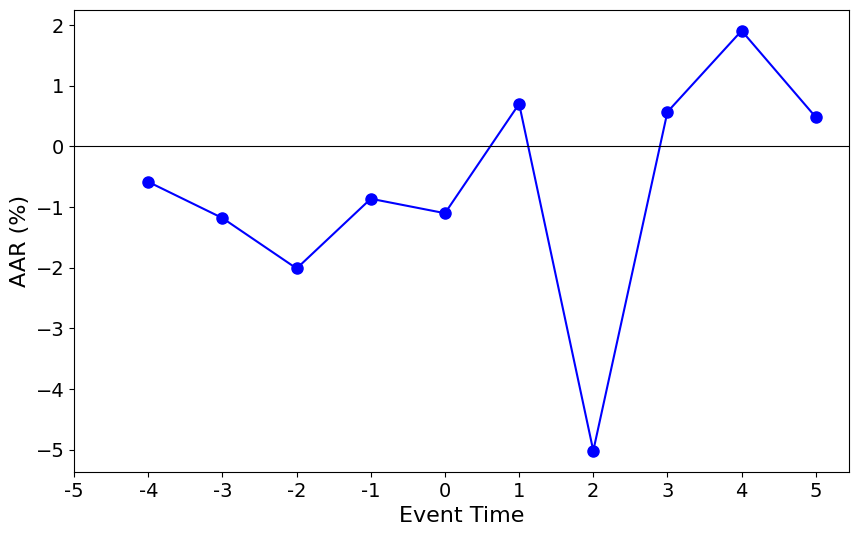

In [27]:
# Plotting the average abnormal returns
plt.figure(figsize=(10, 6)) 
plt.plot(data_all_event['event_time'], 100*data_all_event['average_abnormal_return'], 
         marker='o', linestyle='-', color='b', markersize=8) 
plt.axhline(0, color='black', linewidth=0.8)

## Customizing the plot
plt.xlabel('Event Time', fontsize=16)
plt.ylabel('AAR (%)', fontsize=16)
ticks = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
plt.xticks(ticks, ticks)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Showing the plot
plt.show()

### Significane of ARs and AARs

In [28]:
# Calculating the sample standard errors of ARs
## Equations (4.4) and (4.5)
L1 = data_all_estimation.shape[0]
e_hat_estimation = data_all_event["average_abnormal_return"]
sigma2_hat = np.sum(np.square(e_hat_estimation)) / (L1 - 2)
np.sqrt(sigma2_hat)

np.float64(0.0036786537113226705)

In [29]:
data_all_estimation.head()

,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time
138,2000-07-20,0.000557,-0.026111,-0.003499,0.012357,0.012240,0.022605,0.008243,-294
139,2000-07-21,-0.014104,0.002642,0.011614,0.040401,0.004854,-0.028587,-0.004488,-293
140,2000-07-24,0.000455,-0.017299,0.061575,-0.011012,-0.009732,0.000000,-0.003003,-292
141,2000-07-25,0.001472,-0.020340,0.007572,-0.005980,-0.007362,0.000000,-0.007547,-291
142,2000-07-26,-0.000563,0.029692,0.005373,-0.006016,-0.004939,-0.004008,0.004535,-290


In [30]:
## Equation (5.3)
L2 = data_all_event.shape[0]
V_hat = sigma2_hat*np.eye(L2) + sigma2_hat*X_event@np.linalg.inv(X_estimation.T@X_estimation)@X_event.T.values
V_hat

,0,1,2,3,4,5,6,7,8,9
0,1.391169e-05,1.987853e-07,-3.883078e-07,3.951588e-07,-6.251740e-08,-2.485071e-07,-3.513934e-07,-2.584285e-07,5.116452e-07,1.776340e-07
1,1.987853e-07,1.364924e-05,-1.502195e-07,2.060415e-07,-2.074784e-09,-8.664873e-08,-1.334336e-07,-9.116024e-08,2.590107e-07,1.071278e-07
2,-3.883078e-07,-1.502195e-07,1.415704e-05,-4.093663e-07,1.946120e-07,4.400556e-07,5.758309e-07,4.531485e-07,-5.630891e-07,-1.223070e-07
3,3.951588e-07,2.060415e-07,-4.093663e-07,1.394438e-05,-6.786343e-08,-2.628231e-07,-3.706715e-07,-2.732230e-07,5.339902e-07,1.838702e-07
4,-6.251740e-08,-2.074784e-09,1.946120e-07,-6.786343e-08,1.361796e-05,1.477762e-07,1.822450e-07,1.511000e-07,-1.068885e-07,5.011266e-09
5,-2.485071e-07,-8.664873e-08,4.400556e-07,-2.628231e-07,1.477762e-07,1.384713e-05,4.069382e-07,3.235357e-07,-3.673276e-07,-6.767311e-08
6,-3.513934e-07,-1.334336e-07,5.758309e-07,-3.706715e-07,1.822450e-07,4.069382e-07,1.406373e-05,4.189242e-07,-5.113982e-07,-1.078809e-07
7,-2.584285e-07,-9.116024e-08,4.531485e-07,-2.732230e-07,1.511000e-07,3.235357e-07,4.189242e-07,1.386523e-05,-3.812205e-07,-7.155039e-08
8,5.116452e-07,2.590107e-07,-5.630891e-07,5.339902e-07,-1.068885e-07,-3.673276e-07,-5.113982e-07,-3.812205e-07,1.422960e-05,2.293928e-07
9,1.776340e-07,1.071278e-07,-1.223070e-07,1.838702e-07,5.011266e-09,-6.767311e-08,-1.078809e-07,-7.155039e-08,2.293928e-07,1.363136e-05


In [31]:
## Sample standard errors of ARs
data_all_event['s.e._abnormal_return'] = np.sqrt(np.diag(V_hat))

In [32]:
# Calculating the sample standard errors of CARs
data_all_event['s.e._average_abnormal_return'] = np.sqrt(np.cumsum(np.diag(V_hat)))

In [33]:
# t statistics and p values: Testing the significance of CARs
data_all_event['t_average_abnormal_return'] = data_all_event['average_abnormal_return'] / data_all_event['s.e._average_abnormal_return']
data_all_event['p_average_abnormal_return'] = 2*t.sf(np.abs(data_all_event['t_average_abnormal_return']), L1 - 2)

In [34]:
# Confidence intervals: AARs
data_all_event['upper_average_abnormal_return'] = data_all_event['average_abnormal_return'] + t.ppf(1 - 0.1/2, L1 - 2)*data_all_event['s.e._average_abnormal_return']
data_all_event['lower_average_abnormal_return'] = data_all_event['average_abnormal_return'] - t.ppf(1 - 0.1/2, L1 - 2)*data_all_event['s.e._average_abnormal_return']

In [35]:
data_all_event.head()

,index,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time,...,abnormal_return_DX,abnormal_return_SC,abnormal_return_UU,average_abnormal_return,s.e._abnormal_return,s.e._average_abnormal_return,t_average_abnormal_return,p_average_abnormal_return,upper_average_abnormal_return,lower_average_abnormal_return
0,428,2001-09-12,0.028273,0.000000,0.029853,-0.005362,0.005333,0.006129,0.036368,-4,...,-0.020876,0.005236,0.031110,-0.005868,0.003730,0.003730,-1.573239,0.116801,0.000288,-0.012023
1,429,2001-09-13,0.012518,-0.059423,-0.009852,-0.021740,0.015831,0.050631,-0.001625,-3,...,0.004905,0.050127,-0.003933,-0.011837,0.003694,0.005250,-2.254697,0.024931,-0.003173,-0.020501
2,430,2001-09-14,-0.038750,-0.172169,-0.028114,0.000000,-0.010527,-0.039492,-0.029705,-2,...,0.028278,-0.038731,-0.022417,-0.020145,0.003763,0.006459,-3.118857,0.002006,-0.009485,-0.030804
3,431,2001-09-17,0.029667,0.064539,-0.020577,-0.027857,-0.016000,0.034640,0.026448,-1,...,-0.043561,0.033713,0.020929,-0.008647,0.003734,0.007461,-1.158959,0.247468,0.003666,-0.020959
4,432,2001-09-18,-0.010300,-0.011429,-0.026865,-0.040351,-0.027249,0.001944,-0.008190,0,...,-0.016040,0.002002,-0.006227,-0.011032,0.003690,0.008323,-1.325457,0.186108,0.002704,-0.024769


In [36]:
data_all_event.rename(columns={'average_abnormal_return': 'AAR',
                               's.e._abnormal_return': 's.e._AR',
                               's.e._average_abnormal_return': 's.e._AAR',
                               't_average_abnormal_return': 't_AAR',
                               'p_average_abnormal_return': 'p_AAR',
                               'upper_average_abnormal_return': 'upper_AAR',
                               'lower_average_abnormal_return': 'lower_AAR'}, inplace=True)
data_all_event[['event_time', 's.e._AR', 'AAR', 's.e._AAR', 't_AAR', 'p_AAR', 'upper_AAR', 'lower_AAR']]

,event_time,s.e._AR,AAR,s.e._AAR,t_AAR,p_AAR,upper_AAR,lower_AAR
0,-4,0.003730,-0.005868,0.003730,-1.573239,1.168009e-01,0.000288,-0.012023
1,-3,0.003694,-0.011837,0.005250,-2.254697,2.493066e-02,-0.003173,-0.020501
2,-2,0.003763,-0.020145,0.006459,-3.118857,2.006228e-03,-0.009485,-0.030804
3,-1,0.003734,-0.008647,0.007461,-1.158959,2.474675e-01,0.003666,-0.020959
4,0,0.003690,-0.011032,0.008323,-1.325457,1.861078e-01,0.002704,-0.024769
5,1,0.003721,0.006993,0.009117,0.766978,4.437453e-01,0.022040,-0.008054
6,2,0.003750,-0.050183,0.009859,-5.090323,6.595646e-07,-0.033913,-0.066453
7,3,0.003724,0.005667,0.010538,0.537788,5.911535e-01,0.023059,-0.011725
8,4,0.003772,0.019048,0.011193,1.701729,8.992425e-02,0.037520,0.000575
9,5,0.003692,0.004798,0.011786,0.407061,6.842766e-01,0.024249,-0.014654


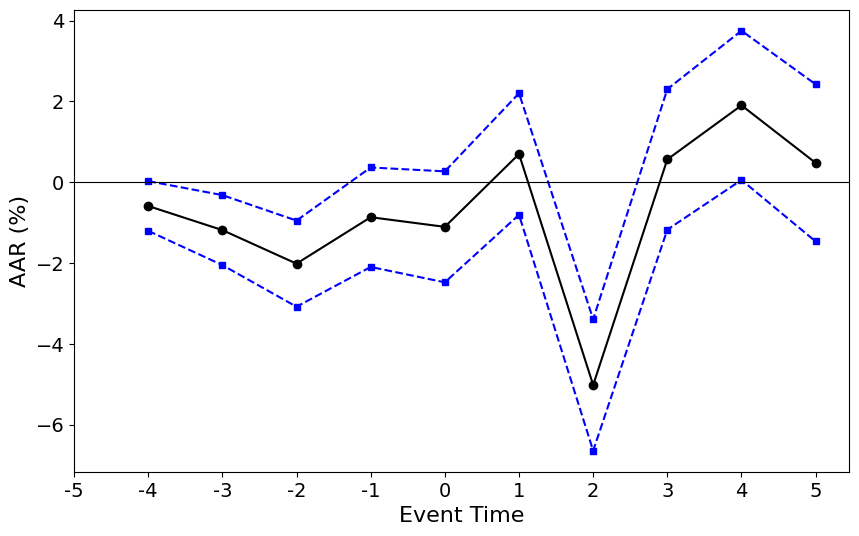

In [37]:
# Plotting the average abnormal returns
plt.figure(figsize=(10, 6)) 
plt.plot(data_all_event['event_time'], 100*data_all_event['AAR'], 
         marker='o', linestyle='-', color='black', markersize=6) 
plt.plot(data_all_event['event_time'], 100*data_all_event['upper_AAR'], 
         marker='s', linestyle='--', color='blue', markersize=4) 
plt.plot(data_all_event['event_time'], 100*data_all_event['lower_AAR'], 
         marker='s', linestyle='--', color='blue', markersize=4) 
plt.axhline(0, color='black', linewidth=0.8)

## Customizing the plot
plt.xlabel('Event Time', fontsize=16)
plt.ylabel('AAR (%)', fontsize=16)
ticks = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
plt.xticks(ticks, ticks)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Showing the plot
plt.show()

In [38]:
# Sample standard errors of ARs
np.sqrt(np.var(e_hat_estimation))

np.float64(0.01804163096682244)

In [39]:
# Sample standard errors of AARs
np.sqrt(np.var(e_hat_estimation) * np.arange(1, 11))

array([0.01804163, 0.02551472, 0.03124902, 0.03608326, 0.04034231,
       0.04419279, 0.04773367, 0.05102944, 0.05412489, 0.05705265])

In [40]:
# t statistics
t_statistic = np.array(data_all_event[['AAR']].T) / np.array(np.sqrt(np.var(e_hat_estimation) * np.arange(1, 11))).T
t_statistic

array([[-0.32524365, -0.4639213 , -0.64464508, -0.23963099, -0.27347009,
         0.15823547, -1.05131756,  0.11106117,  0.35192046,  0.08409336]])

In [41]:
data_all_event.head()

,index,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time,...,abnormal_return_DX,abnormal_return_SC,abnormal_return_UU,AAR,s.e._AR,s.e._AAR,t_AAR,p_AAR,upper_AAR,lower_AAR
0,428,2001-09-12,0.028273,0.000000,0.029853,-0.005362,0.005333,0.006129,0.036368,-4,...,-0.020876,0.005236,0.031110,-0.005868,0.003730,0.003730,-1.573239,0.116801,0.000288,-0.012023
1,429,2001-09-13,0.012518,-0.059423,-0.009852,-0.021740,0.015831,0.050631,-0.001625,-3,...,0.004905,0.050127,-0.003933,-0.011837,0.003694,0.005250,-2.254697,0.024931,-0.003173,-0.020501
2,430,2001-09-14,-0.038750,-0.172169,-0.028114,0.000000,-0.010527,-0.039492,-0.029705,-2,...,0.028278,-0.038731,-0.022417,-0.020145,0.003763,0.006459,-3.118857,0.002006,-0.009485,-0.030804
3,431,2001-09-17,0.029667,0.064539,-0.020577,-0.027857,-0.016000,0.034640,0.026448,-1,...,-0.043561,0.033713,0.020929,-0.008647,0.003734,0.007461,-1.158959,0.247468,0.003666,-0.020959
4,432,2001-09-18,-0.010300,-0.011429,-0.026865,-0.040351,-0.027249,0.001944,-0.008190,0,...,-0.016040,0.002002,-0.006227,-0.011032,0.003690,0.008323,-1.325457,0.186108,0.002704,-0.024769


In [42]:
# p values
2*t.sf(np.abs(t_statistic), data_all_estimation.shape[0] - 2)

array([[0.74524131, 0.64306718, 0.51968879, 0.81079292, 0.78469494,
        0.87438614, 0.29402576, 0.91164798, 0.72516453, 0.93304272]])